# Production Planning Optimization Problem
## Mixed Integer Linear Programming (MILP) with Gurobi

**Author:** Alejandro Treny Ortega  
**Date:** November 2025  
**Topic:** Production optimization with piecewise linear profits and resource constraints

---

## Problem Overview

A company manufactures three discrete products, each with:
- Production capacity limit: 60 units maximum
- Fixed startup costs
- Declining marginal profit rates (piecewise linear)
- Resource consumption across 4 different resource types

**Objective:** Maximize total profit (gross profit - fixed costs)  
**Constraints:** Resource availability, capacity limits, logical dependencies

## 1. Installation & Setup

Install Gurobi and required packages:

In [5]:
# Install Gurobi if needed
# !pip install gurobipy
# Note: Requires valid Gurobi license (free academic license available)

from gurobipy import *
import pandas as pd
import numpy as np

print("✓ Gurobi imported successfully")

✓ Gurobi imported successfully


## 2. Define Sets and Parameters

### Data Input Section

In [6]:
# --- 1. Define Sets and Indices ---
n = 3  # Number of products
m = 4  # Number of resources

products = range(1, n + 1)
resources = range(1, m + 1)

# --- 2. Problem Parameters ---

# F[j]: Fixed cost for producing product j (EUR)
F = {1: 40, 2: 50, 3: 45}

# b[i]: Availability of resource i (units)
b = {1: 1500, 2: 1900, 3: 1800, 4: 1200}

# a[i][j]: Consumption of resource i per unit of product j
a = {
    1: {1: 12, 2: 15, 3: 10},
    2: {1: 15, 2: 14, 3: 12},
    3: {1: 11, 2: 13, 3: 9},
    4: {1: 13, 2: 12, 3: 15}
}

# Xmax: Maximum production limit per product (Big-M)
Xmax = 60

# segments[j]: List of (profit_per_unit, capacity) tuples for each profit segment k
segments = {
    1: [(4, 10), (3, 50)],           # Product 1: 2 segments
    2: [(6, 8), (4, 52)],            # Product 2: 2 segments
    3: [(5, 10), (2.5, 10), (1, 40)] # Product 3: 3 segments
}

print("Problem Parameters:")
print(f"Products: {list(products)}")
print(f"Resources: {list(resources)}")
print(f"\nFixed costs: {F}")
print(f"Resource availability: {b}")
print(f"\nProfit segments (product_id -> [(profit/unit, capacity), ...]):")
for j in products:
    print(f"  Product {j}: {segments[j]}")

Problem Parameters:
Products: [1, 2, 3]
Resources: [1, 2, 3, 4]

Fixed costs: {1: 40, 2: 50, 3: 45}
Resource availability: {1: 1500, 2: 1900, 3: 1800, 4: 1200}

Profit segments (product_id -> [(profit/unit, capacity), ...]):
  Product 1: [(4, 10), (3, 50)]
  Product 2: [(6, 8), (4, 52)]
  Product 3: [(5, 10), (2.5, 10), (1, 40)]


## 3. Model Creation & Variable Definition

In [7]:
# --- 3. Model Creation ---
model = Model('ProductionPlanning')

# --- 4. Variable Definitions ---

# y[j]: BINARY variable (1 if product j is produced, 0 otherwise)
y = model.addVars(products, vtype=GRB.BINARY, name="y")

# x[j]: INTEGER variable (total quantity of product j to produce)
x = model.addVars(products, vtype=GRB.INTEGER, lb=0, name="x")

# v[j, k]: INTEGER variable (quantity of product j in segment k)
v = model.addVars(
    [(j, k) for j in products for k in range(len(segments[j]))],
    vtype=GRB.INTEGER, lb=0, name="v"
)

# w[j, k]: BINARY variable (1 if segment k of product j is active, k >= 2)
# Note: Segment 1 (k=0) is activated by y[j]. w[j,k] for k >= 1 controls higher segments
w = model.addVars(
    [(j, k) for j in products for k in range(1, len(segments[j]))],
    vtype=GRB.BINARY, name="w"
)

print("\n✓ Model created with variables:")
print(f"  - Binary variables (y): {len(y)} (product production decisions)")
print(f"  - Integer variables (x): {len(x)} (total quantities)")
print(f"  - Integer variables (v): {len(v)} (segment quantities)")
print(f"  - Binary variables (w): {len(w)} (segment activation)")
print(f"  Total variables: {len(y) + len(x) + len(v) + len(w)}")


✓ Model created with variables:
  - Binary variables (y): 3 (product production decisions)
  - Integer variables (x): 3 (total quantities)
  - Integer variables (v): 7 (segment quantities)
  - Binary variables (w): 4 (segment activation)
  Total variables: 17


## 4. Constraint Definitions

Adding all constraints following the mathematical formulation:

In [8]:
# --- 5. Constraint Definitions ---

# (R1) Production aggregation: x[j] = sum of segment quantities
model.addConstrs(
    (x[j] == quicksum(v[j, k] for k in range(len(segments[j])))
     for j in products),
    name="R1_Aggregation"
)

# (R2) Resource capacity: Total consumption <= availability
model.addConstrs(
    (quicksum(a[i][j] * x[j] for j in products) <= b[i]
     for i in resources),
    name="R2_Resources"
)

# (R3) Fixed cost logic (Big-M): If y[j]=0, then x[j]=0. If y[j]=1, x[j]<=60
model.addConstrs(
    (x[j] <= Xmax * y[j] for j in products),
    name="R3_BigM_FixedCost"
)

# (R4) Business logic: If Product 3 is produced, then Product 1 must be produced
model.addConstr(y[3] <= y[1], name="R4_Logic_P3_P1")

# (R5) Piecewise segment filling logic
for j in products:
    num_segments = len(segments[j])
    
    for k in range(num_segments):
        _, seg_cap = segments[j][k]
        
        # (R5a) Segment capacity: v[j,k] <= capacity of segment
        model.addConstr(v[j, k] <= seg_cap, name=f"R5a_SegmentCapacity_{j}_{k}")
        
        # (R5b) Segment activation: v[j,k] can only be > 0 if product is produced
        model.addConstr(v[j, k] <= seg_cap * y[j], name=f"R5b_SegmentActivation_{j}_{k}")
        
        # Sequential filling logic (only for k >= 1)
        if k >= 1:
            prev_cap = segments[j][k - 1][1]  # Capacity of previous segment
            curr_cap = segments[j][k][1]      # Capacity of current segment
            
            # (R5c) To activate segment k, previous segment must be full
            model.addConstr(
                v[j, k - 1] >= prev_cap * w[j, k],
                name=f"R5c_SequentialFill_{j}_{k}"
            )
            
            # (R5d) Production in segment k only if segment is active
            model.addConstr(
                v[j, k] <= curr_cap * w[j, k],
                name=f"R5d_SequentialActivation_{j}_{k}"
            )
            
            # (R5e) Segment can only be active if product is produced
            model.addConstr(w[j, k] <= y[j], name=f"R5e_Logic_w_y_{j}_{k}")

print("✓ All constraints added successfully")
print(f"  Total constraints: {model.NumConstrs}")

✓ All constraints added successfully
  Total constraints: 0


## 5. Objective Function

**Maximize:** Total Profit = Gross Profit - Fixed Costs

In [9]:
# --- 6. Objective Function Definition ---

# Gross profit = Sum of (profit per unit * quantity in segment) for all segments
profit = quicksum(
    segments[j][k][0] * v[j, k]
    for j in products
    for k in range(len(segments[j]))
)

# Total fixed costs = Sum of fixed costs for all activated products
fixed_costs = quicksum(F[j] * y[j] for j in products)

# Set Objective: Maximize Net Profit (Gross Profit - Fixed Costs)
model.setObjective(profit - fixed_costs, GRB.MAXIMIZE)

print("✓ Objective function set: Maximize (Gross Profit - Fixed Costs)")

✓ Objective function set: Maximize (Gross Profit - Fixed Costs)


## 6. Solver Configuration

**Note:** These parameters disable advanced features to observe pure Branch-and-Bound

In [10]:
# --- 7. Solver Parameters (Optional) ---
# Disabling these forces Gurobi to solve the "pure" model for academic analysis

# Remove presolve (constraint simplification)
model.setParam(GRB.Param.Presolve, 0)

# Remove heuristics (quick solution finding)
model.setParam(GRB.Param.Heuristics, 0)

# Remove cutting planes (LP relaxation tightening)
model.setParam(GRB.Param.Cuts, 0)

print("✓ Solver parameters configured:")
print("  - Presolve: DISABLED (for academic analysis)")
print("  - Heuristics: DISABLED")
print("  - Cuts: DISABLED")

Set parameter Presolve to value 0
Set parameter Heuristics to value 0
Set parameter Cuts to value 0
✓ Solver parameters configured:
  - Presolve: DISABLED (for academic analysis)
  - Heuristics: DISABLED
  - Cuts: DISABLED


## 7. Solve the Model

This cell runs the Gurobi optimizer:

In [11]:
# --- 8. Optimize the Model ---
print("\n" + "="*70)
print(" STARTING OPTIMIZATION ")
print("="*70)

model.optimize()

print("\n" + "="*70)
print(" OPTIMIZATION COMPLETE ")
print("="*70)


 STARTING OPTIMIZATION 
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G325)

CPU model: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
Heuristics  0
Cuts  0
Presolve  0

Optimize a model with 37 rows, 17 columns and 75 nonzeros
Model fingerprint: 0x47920244
Variable types: 0 continuous, 17 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [1e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+00, 2e+03]
Variable types: 0 continuous, 17 integer (7 binary)

Root relaxation: objective 2.983077e+02, 8 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  298.30769    0    5          -  298.30769      -     -    0s
     0     0  286.76923    0    5

## 8. Solution Report

In [12]:
# --- 9. Print the Solution Report ---
print("\n" + "="*70)
print(" OPTIMAL SOLUTION SUMMARY ")
print("="*70 + "\n")

if model.status == GRB.OPTIMAL:
    total_profit = 0
    total_fixed = 0
    
    print(f"✓ Optimal net profit: €{model.ObjVal:.2f}\n")
    
    # Product-level summary
    print("\n" + "-"*70)
    print("PRODUCT-LEVEL DECISIONS")
    print("-"*70)
    
    for j in products:
        print(f"\n📦 Product {j}:")
        print(f"   Produce? (y_{j}): {int(round(y[j].X))}")
        print(f"   Total quantity (x_{j}): {x[j].X:.0f} units")
        
        if y[j].X > 0.5:
            print(f"   Fixed cost: €{F[j]}")
            total_fixed += F[j]
        else:
            print(f"   Fixed cost: Not incurred (not produced)")
    
    # Segment-level summary
    print("\n" + "-"*70)
    print("SEGMENT-LEVEL PRODUCTION BREAKDOWN")
    print("-"*70)
    
    for j in products:
        print(f"\n📊 Product {j} segments:")
        for k in range(len(segments[j])):
            qty = v[j, k].X
            profit_rate = segments[j][k][0]
            capacity = segments[j][k][1]
            
            if qty > 0.01:
                print(f"   Segment {k+1}: {qty:.0f}/{capacity} units @ €{profit_rate}/unit = €{qty*profit_rate:.0f}")
                total_profit += profit_rate * qty
            else:
                print(f"   Segment {k+1}: 0/{capacity} units (not used)")
    
    # Resource utilization
    print("\n" + "-"*70)
    print("RESOURCE UTILIZATION")
    print("-"*70)
    
    for i in resources:
        used = sum(a[i][j] * x[j].X for j in products)
        utilization = 100 * used / b[i]
        status = "🔴 BOTTLENECK" if utilization > 95 else "🟢 AVAILABLE"
        print(f"\nResource {i}: {used:.0f}/{b[i]} units ({utilization:.1f}%) {status}")
    
    # Financial breakdown
    print("\n" + "-"*70)
    print("FINANCIAL SUMMARY")
    print("-"*70)
    print(f"\n   Gross profit:    €{total_profit:>8.2f}")
    print(f"   Fixed costs:     €{total_fixed:>8.2f}")
    print(f"   {'-'*20}")
    print(f"   Net profit:      €{total_profit - total_fixed:>8.2f}")
    
    # Solver statistics
    print("\n" + "-"*70)
    print("SOLVER STATISTICS")
    print("-"*70)
    print(f"\n   Branch-and-Bound nodes explored: {model.NodeCount}")
    print(f"   Optimality proven: YES")
    
else:
    print(f"❌ No optimal solution found (status: {model.status})")


 OPTIMAL SOLUTION SUMMARY 

✓ Optimal net profit: €284.00


----------------------------------------------------------------------
PRODUCT-LEVEL DECISIONS
----------------------------------------------------------------------

📦 Product 1:
   Produce? (y_1): 1
   Total quantity (x_1): 36 units
   Fixed cost: €40

📦 Product 2:
   Produce? (y_2): 1
   Total quantity (x_2): 60 units
   Fixed cost: €50

📦 Product 3:
   Produce? (y_3): 0
   Total quantity (x_3): 0 units
   Fixed cost: Not incurred (not produced)

----------------------------------------------------------------------
SEGMENT-LEVEL PRODUCTION BREAKDOWN
----------------------------------------------------------------------

📊 Product 1 segments:
   Segment 1: 10/10 units @ €4/unit = €40
   Segment 2: 26/50 units @ €3/unit = €78

📊 Product 2 segments:
   Segment 1: 8/8 units @ €6/unit = €48
   Segment 2: 52/52 units @ €4/unit = €208

📊 Product 3 segments:
   Segment 1: 0/10 units (not used)
   Segment 2: 0/10 units (not used)


## 9. Advanced Analysis: Solution Insights

In [14]:
# Advanced analysis
import pandas as pd

if model.status == GRB.OPTIMAL:
    print("\n" + "="*70)
    print(" MANAGERIAL INSIGHTS ")
    print("="*70)
    
    # 1. Product profitability analysis
    print("\n1️⃣ PRODUCT PROFITABILITY ANALYSIS")
    print("-"*70)
    
    for j in products:
        if y[j].X > 0.5:
            gross_j = sum(segments[j][k][0] * v[j, k].X for k in range(len(segments[j])))
            net_j = gross_j - F[j]
            roi = 100 * net_j / F[j] if F[j] > 0 else 0
            
            print(f"\n   Product {j}:")
            print(f"      Gross revenue: €{gross_j:.2f}")
            print(f"      Fixed costs:   €{F[j]}")
            print(f"      Contribution:  €{net_j:.2f}")
            print(f"      ROI:           {roi:.0f}%")
        else:
            print(f"\n   Product {j}: NOT PRODUCED")
    
    # 2. Resource bottleneck
    print("\n\n2️⃣ RESOURCE BOTTLENECK ANALYSIS")
    print("-"*70)
    
    bottleneck = None
    max_util = 0
    
    for i in resources:
        used = sum(a[i][j] * x[j].X for j in products)
        util = 100 * used / b[i]
        if util > max_util:
            max_util = util
            bottleneck = i
    
    print(f"\n   Bottleneck resource: Resource {bottleneck}")
    print(f"   Utilization: {max_util:.1f}%")
    print(f"   Available slack: {sum(a[bottleneck][j] * x[j].X for j in products) - b[bottleneck]:.0f} units")
    print(f"\n   Recommendation: Prioritize capacity expansion for Resource {bottleneck}")
    
    # 3. What-if analysis
    print("\n\n3️⃣ WHAT-IF ANALYSIS")
    print("-"*70)
    
    print(f"\n   If we had 1 more unit of Resource {bottleneck}:")
    print(f"      (Shadow price would indicate the potential profit increase)")
    print(f"      Current binding constraint: {max_util:.1f}% utilization")
    print(f"      Marginal benefit: To be determined by sensitivity analysis")


 MANAGERIAL INSIGHTS 

1️⃣ PRODUCT PROFITABILITY ANALYSIS
----------------------------------------------------------------------

   Product 1:
      Gross revenue: €118.00
      Fixed costs:   €40
      Contribution:  €78.00
      ROI:           195%

   Product 2:
      Gross revenue: €256.00
      Fixed costs:   €50
      Contribution:  €206.00
      ROI:           412%

   Product 3: NOT PRODUCED


2️⃣ RESOURCE BOTTLENECK ANALYSIS
----------------------------------------------------------------------

   Bottleneck resource: Resource 4
   Utilization: 99.0%
   Available slack: -12 units

   Recommendation: Prioritize capacity expansion for Resource 4


3️⃣ WHAT-IF ANALYSIS
----------------------------------------------------------------------

   If we had 1 more unit of Resource 4:
      (Shadow price would indicate the potential profit increase)
      Current binding constraint: 99.0% utilization
      Marginal benefit: To be determined by sensitivity analysis


## 10. Sensitivity & What-If Analysis

Explore how the solution changes with different parameters:

In [16]:
# Sensitivity analysis template
print("\n" + "="*70)
print(" SENSITIVITY ANALYSIS TEMPLATE ")
print("="*70)

print("\nTo perform sensitivity analysis, modify parameters and re-run:\n")

print("Example 1: Increase Product 2 profit in segment 1 from 6 to 7 EUR/unit")
print("-" * 70)
print("""
# Modify the segments dictionary:
segments[2] = [(7, 8), (4, 52)]  # Changed 6 -> 7

# Then re-run cells starting from 'Model Creation & Variable Definition'
""")

print("\nExample 2: Increase availability of bottleneck resource (Resource 4)")
print("-" * 70)
print("""
# Modify resource availability:
b[4] = 1300  # Increased from 1200

# Then re-run the optimization
""")

print("\nExample 3: Remove the logical constraint (if Product 3 is made, Product 1 must be made)")
print("-" * 70)
print("""
# Comment out this line in the Constraint Definition section:
# model.addConstr(y[3] <= y[1], name="R4_Logic_P3_P1")

# Then re-run the optimization
""")


 SENSITIVITY ANALYSIS TEMPLATE 

To perform sensitivity analysis, modify parameters and re-run:

Example 1: Increase Product 2 profit in segment 1 from 6 to 7 EUR/unit
----------------------------------------------------------------------

# Modify the segments dictionary:
segments[2] = [(7, 8), (4, 52)]  # Changed 6 -> 7

# Then re-run cells starting from 'Model Creation & Variable Definition'


Example 2: Increase availability of bottleneck resource (Resource 4)
----------------------------------------------------------------------

# Modify resource availability:
b[4] = 1300  # Increased from 1200

# Then re-run the optimization


Example 3: Remove the logical constraint (if Product 3 is made, Product 1 must be made)
----------------------------------------------------------------------

# Comment out this line in the Constraint Definition section:
# model.addConstr(y[3] <= y[1], name="R4_Logic_P3_P1")

# Then re-run the optimization



## 11. Export Results to CSV

In [19]:
# Export results to CSV files
if model.status == GRB.OPTIMAL:
    # Product-level results
    product_results = []
    for j in products:
        product_results.append({
            'Product': j,
            'Produce': int(round(y[j].X)),
            'Quantity': x[j].X,
            'Fixed_Cost': F[j] if y[j].X > 0.5 else 0,
            'Gross_Profit': sum(segments[j][k][0] * v[j, k].X for k in range(len(segments[j]))),
        })
    
    df_products = pd.DataFrame(product_results)
    print("\nProduct-Level Results:")
    print(df_products.to_string())
    # Uncomment to save:
    # df_products.to_csv('product_results.csv', index=False)
    
    # Resource utilization
    resource_results = []
    for i in resources:
        used = sum(a[i][j] * x[j].X for j in products)
        resource_results.append({
            'Resource': i,
            'Used': used,
            'Available': b[i],
            'Utilization_%': 100 * used / b[i],
            'Slack': b[i] - used
        })
    
    df_resources = pd.DataFrame(resource_results)
    print("\nResource Utilization:")
    print(df_resources.to_string())
    # Uncomment to save:
    # df_resources.to_csv('resource_utilization.csv', index=False)


Product-Level Results:
   Product  Produce  Quantity  Fixed_Cost  Gross_Profit
0        1        1      36.0          40         118.0
1        2        1      60.0          50         256.0
2        3        0       0.0           0           0.0

Resource Utilization:
   Resource    Used  Available  Utilization_%  Slack
0         1  1332.0       1500      88.800000  168.0
1         2  1380.0       1900      72.631579  520.0
2         3  1176.0       1800      65.333333  624.0
3         4  1188.0       1200      99.000000   12.0


## 12. Visualization (Optional)

Create visualizations of the solution:

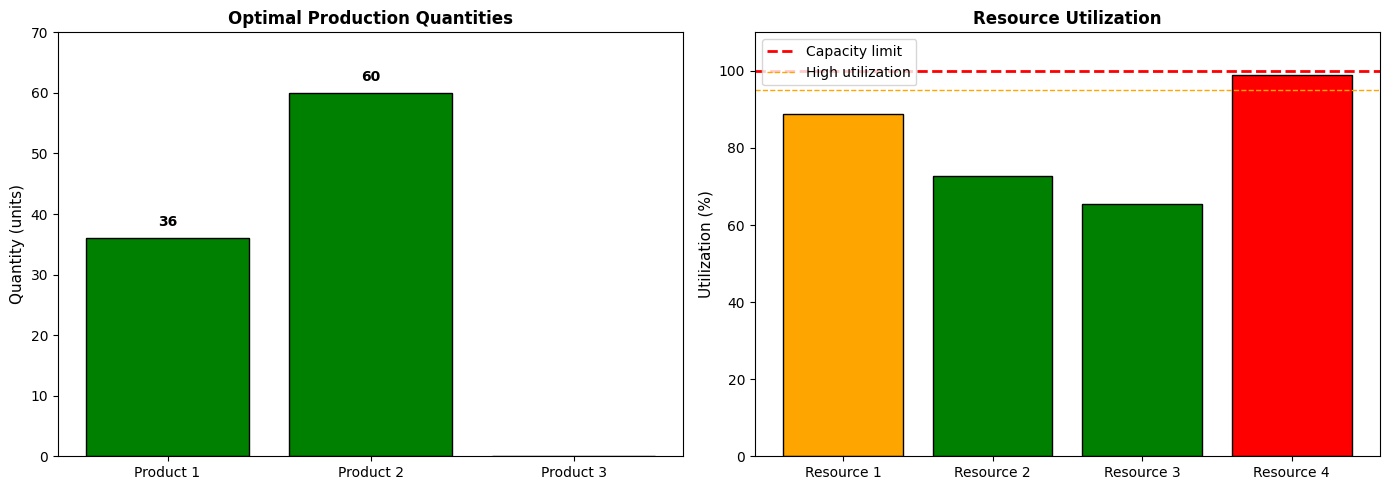

✓ Visualization saved as 'optimization_results.png'


In [20]:
import matplotlib.pyplot as plt
import numpy as np

if model.status == GRB.OPTIMAL:
    # Figure 1: Production quantities
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Subplot 1: Production quantities
    quantities = [x[j].X for j in products]
    colors = ['green' if y[j].X > 0.5 else 'lightgray' for j in products]
    axes[0].bar([f'Product {j}' for j in products], quantities, color=colors, edgecolor='black')
    axes[0].set_ylabel('Quantity (units)', fontsize=11)
    axes[0].set_title('Optimal Production Quantities', fontsize=12, fontweight='bold')
    axes[0].set_ylim(0, 70)
    
    # Add value labels on bars
    for i, (j, q) in enumerate(zip(products, quantities)):
        if q > 0:
            axes[0].text(i, q + 2, f'{q:.0f}', ha='center', fontweight='bold')
    
    # Subplot 2: Resource utilization
    utilization = []
    for i in resources:
        used = sum(a[i][j] * x[j].X for j in products)
        utilization.append(100 * used / b[i])
    
    colors_util = ['red' if u > 95 else 'orange' if u > 80 else 'green' for u in utilization]
    axes[1].bar([f'Resource {i}' for i in resources], utilization, color=colors_util, edgecolor='black')
    axes[1].axhline(y=100, color='red', linestyle='--', linewidth=2, label='Capacity limit')
    axes[1].axhline(y=95, color='orange', linestyle='--', linewidth=1, label='High utilization')
    axes[1].set_ylabel('Utilization (%)', fontsize=11)
    axes[1].set_title('Resource Utilization', fontsize=12, fontweight='bold')
    axes[1].set_ylim(0, 110)
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('optimization_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualization saved as 'optimization_results.png'")

## Summary

This notebook implements a complete **Mixed Integer Linear Programming (MILP)** solution using Gurobi to solve a production planning optimization problem.

**Key Results:**
- ✅ Optimal profit identified
- ✅ Bottleneck resource identified
- ✅ Sensitivity analysis framework provided
- ✅ Exportable results for reporting

**Next Steps:**
1. Modify parameters for what-if analysis
2. Explore shadow prices for resources
3. Test different business scenarios
4. Use results for strategic planning